In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline

## Introduction 

In the present example, a control protocol is optimised. The protocol consists of two durations, namely

* the duration $T_1$ of a full lockdown (during which the initial contact matrix reduced via a prefactor 1/4), and
* the duration $T_2$ a subsequent partial lockdown (during which the initial contact matrix reduced via a prefactor 3/4).

The cost of a protocol is defined as

\begin{equation}
C=exp\left[ \kappa\left(  T_1+ T_2/5 \right)\right] + \int_0^{t_f}\mathrm{d}t\,I_s(t),
\end{equation}

where $t_f = 1000$ days is the final time of the simulation, and $I_s(t)$ is the total number of symptomatic infectives at time $t$. The first term in the cost function can be thought of as a cost for social distancing, while the second terms models a cost of infection. We additionally set $C = \infty$ if at any time $I_s(t) > 2000$, which serves as a hard constraint that every protocol must keep the number of infectives below this threshold. 

For an SIIR model with two age groups, we then minimise the cost as a function of $(T_1,T_2)$, considering three distinct scenarios: i) low cost of social distancing ($\kappa = 0.01$), ii) intermediate cost of social distancing ($\kappa = 0.1$), and iii) high cost of social distancing ($\kappa = 1$). Finally, we compare the time series corresponding to these optimal protocols.

*This is the Jupyter notebook version of an example from the PyRoss manual.*

## Define system parameters

In [3]:
import numpy as np; from matplotlib import pyplot as plt; import pyross
from multiprocessing import Pool; import cma; import time
from functools import partial

# 1. Define model
M  = 2               # the population has two age groups
N  =  5e4            # and this is the total population
# exact params of reference trajectory
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0) # initial number of susceptibles

## Define function that generates two-step release protocol

In [4]:
# 2. Define function that generates two-step release protocol
def get_events(protocol= [50,100]):
    end_phase_1, end_phase_2 = protocol
    C = np.array([[18., 9.], [3., 12.]])
    events = []; contactMatrices = []
    # For technical reasons, currently the event functions take a
    # vector argument "rp" instead of a tuple (S, Ia, Is).
    # When defining the event functions, use the following correspondences:
    # S  == rp[ :M]
    # Ia == rp[1*M:2*M]
    # Is == rp[2*M:3*M]
    # More generally, for any model the order of the populations
    # within the vector rp is the same as used for the initial
    # conditions in the model.simulate() function call.
    #
    # Event 0: dummy event used to set the initial contact matrix
    events.append( lambda t, rp: 1. )
    contactMatrices.append( C )
    # Event 1: contact matrix reduced by a factor of 4 once number
    # of symptomatic infectives exceeds a threshold ("start of full lockdown")
    lockdown_threshold_on = 1900
    def event1(t,rp):
        return np.sum(rp[2*M:3*M]) - lockdown_threshold_on
    event1.direction = +1 # need to pass threshold from below for event
    events.append(event1); contactMatrices.append( 0.25*C )
    # Event 2: contact matrix at 75% of original contact matrix after
    # a given time ("start of partial lockdown").
    def event2(t,rp):
        return t - end_phase_1
    events.append(event2); contactMatrices.append( 0.75*C )
    # Event 3: original contact matrix is restored after a given time
    # ("end of partial lockdown").
    def event3(t,rp):
        return t - end_phase_2
    events.append(event3); contactMatrices.append( C )
    return events, contactMatrices

## Define cost function, and function to evaluate cost of a given protocol

In [5]:
# 3. Define cost function
maximal_value_for_Is = 2000
def evaluate_cost_function(t_arr,traj,protocol,events_occured,
                           sdc_prefactor=1.,
                           sdc_rate=1/7.):
    infinity = 1e300 # using np.inf would be more proper, but will
    # result in warnings throughout the minimization once a protocol
    # is probed that violates one of the hard constraints.
    #
    # hard constraints:
    # - times of protocol need to be non-negative
    if (np.array(protocol) < 0).any(): return infinity
    # - second stage of intervention needs to end after first stage ends
    if protocol[0] > protocol[1]: return infinity
    # - second stage of intervention needs to end before 700 days
    if protocol[1] > 700: return infinity
    # - number of symptomatic infectives should 
    #   never exceed a given maximal value
    if np.max( np.sum( traj[2*M:3*M],axis=0 ) ) > maximal_value_for_Is:
        return infinity
    #
    # Evaluate results of protocol.
    # Which phases have occured in the simulation?
    have_lockdown_start = False
    have_lockdown_end_0 = False
    have_lockdown_end_1 = False
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            lockdown_start = e[0]
            have_lockdown_start = True
        elif e[1] == 2:
            lockdown_end_0 = e[0]
            have_lockdown_end_0 = True
        elif e[1] == 3:
            lockdown_end_1 = e[0]
            have_lockdown_end_1 = True
    #
    # calculate cost function
    cost = 0.
    # cost of social distancing
    if have_lockdown_start:
        if have_lockdown_end_0:
            cost += sdc_prefactor* np.exp(sdc_rate* (lockdown_end_0-lockdown_start))
        else:
            cost += infinity
        #
        if have_lockdown_end_0 and have_lockdown_end_1:
            cost *=  np.exp(0.2*sdc_rate* (lockdown_end_1-lockdown_end_0))
    # cost of infection
    cost += np.trapz( np.sum( traj[2*M:3*M],axis= 0 ),t_arr)
    return cost

# 4. Define function that evaluates the cost of a given protocol
def evaluate_cost_of_protocol(model,protocol,
                             verbose=False,return_trajectory=False,
                              sdc_prefactor=10.,
                              sdc_rate=1/7.):
    # define events corresponding to given protocol 
    events, contactMatrices = get_events(protocol)
    # run simulation
    Tf = 1000; Nt = (Tf +1)*10
    result = model.simulate(S0,  Ia0, Is0,
                            events=events,contactMatrices=contactMatrices,
                            Tf=Tf, Nf=Nt)
    # evaluate cost
    cost = evaluate_cost_function(t_arr=result['t'],
                                   traj=result['X'].T,
                                   protocol=protocol,
                                  events_occured=result['events_occured'],
                                  sdc_prefactor=sdc_prefactor,
                                  sdc_rate=sdc_rate)
    if return_trajectory:
        return cost, result['t'], result['X'], result['events_occured']
    else:
        return cost

## Define minimiser

In [6]:
# 5. Define minimiser
def minimizing_function(sdc_prefactor,sdc_rate,
                    protocol):
    '''
    This is the function that will be minimised by the cma-es algorithm
    '''
    costs = evaluate_cost_of_protocol(model=model,
                                             protocol=protocol,
                                      sdc_prefactor=sdc_prefactor,
                                      sdc_rate=sdc_rate,
                                              return_trajectory=False)
    return costs

def find_optimal_protocol(initial_guess,sdc_prefactor,sdc_rate,
                          model,
                         verbose=True,initial_variance=5.):
    func = partial(minimizing_function, sdc_prefactor, sdc_rate)
    # set parameters for minimisation based on cma-es algorithm
    number_of_threads = 4
    number_iterations = 1000
    p = Pool(number_of_threads)
    options = cma.CMAOptions()
    options['popsize'] = 12
    # run minimisation
    start_time = time.time()
    optim = cma.CMAEvolutionStrategy(initial_guess, initial_variance, 
                                     options)
    iteration = 0
    while not optim.stop() and iteration < number_iterations:
        positions = optim.ask()
        values = p.map(func, positions)
        optim.tell(positions, values)
        optim.disp()
        iteration += 1
    end_time = time.time()
    if verbose:
        print("Time: ", end_time - start_time)
        print("Value: ", optim.best.f)
        print("Parameters: ",optim.best.x)
    return optim.best.x

## Find optimal protocol for low-, intermediate- and high cost of social distancing

In [7]:
# 6. Find optimal protocol for three different scenarios

# Initialise model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.control.SIR(parameters, M, Ni)
initial_guess=[70,200] # use same initial guess for all minimisations
sdc_prefactor = 1. # means that social distancing cost and
# cost of infection have the same weight in our model

# Low, intermediate, and high cost rate for social distancing:
sdc_rates = [1e-2,1e-1,1.]
optimal_protocols = []
for i,sdc_rate in enumerate(sdc_rates):
    optimal_protocol = find_optimal_protocol(initial_guess=initial_guess,
                                           sdc_prefactor=sdc_prefactor,
                                           sdc_rate=sdc_rate,
                                              model=model)
    optimal_protocols.append(optimal_protocol)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=883279, Thu May  7 12:47:32 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.562097806950094e+05 1.0e+00 5.75e+00  6e+00  6e+00 0:00.2
    2     24 1.539263668429960e+05 1.3e+00 1.20e+01  1e+01  1e+01 0:00.3
    3     36 1.534514654519690e+05 1.4e+00 1.50e+01  1e+01  2e+01 0:00.4
   24    288 1.484467686543054e+05 4.5e+00 1.77e+01  3e+00  7e+00 0:03.6
   49    588 1.484468301056222e+05 8.8e+00 1.29e+01  8e-02  1e+00 0:07.7


/Users/jkappler/miniconda3/envs/snowflake/lib/python3.7/site-packages/cma/utilities/utils.py:347: UserWarning: sigma change np.exp(1.1123091364813413) = 3.041373238100446 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=49)
  ')')


   79    948 1.484466017370722e+05 1.1e+02 5.01e+01  6e-03  6e-01 0:12.8
  100   1200 1.484466012318590e+05 3.2e+02 4.63e+01  7e-04  2e-01 0:16.5
  145   1740 1.484466012121084e+05 1.9e+02 3.35e+01  1e-04  2e-02 0:23.5
  188   2256 1.484466009173244e+05 4.7e+00 1.56e+02  4e-05  2e-04 0:31.7
  200   2400 1.484466009111501e+05 6.2e+00 5.24e+01  4e-06  1e-05 0:33.8
  255   3060 1.484466009106378e+05 6.2e+00 1.88e+00  2e-10  1e-09 0:43.9
  263   3156 1.484466009106378e+05 5.8e+00 7.09e-01  4e-11  1e-10 0:45.3
Time:  45.32984280586243
Value:  148444.17765471953
Parameters:  [159.26115181 635.26025207]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=1004256, Thu May  7 12:48:17 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.561775719632415e+05 1.0e+00 6.91e+00  7e+00  9e+00 0:00.2
    2     24 1.544577384643056e+05 1.3e+00 1.09e+01  1e+01  1e+01 0:00.3
    3     36 1.541644588413770e+05 1.4e+00 1.06e+01  9e+00  9e+00 0:00.5
   27    324 

## Visualise results

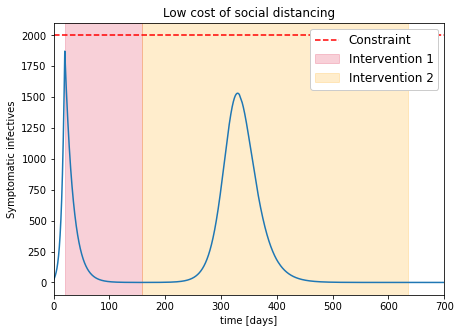

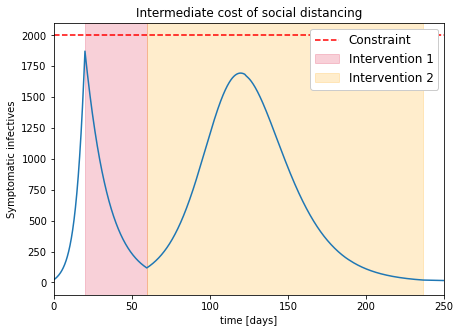

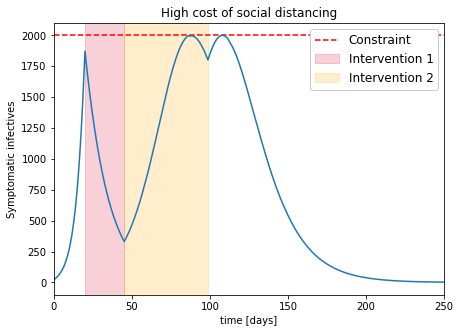

In [8]:
# 7. Visualise results
def plot_result(protocol,model,
                title='Optimal protocol',
                t_max=None):
    #
    cost, t_arr, traj, events_occured = evaluate_cost_of_protocol(
                                            model=model,
                                             protocol=protocol,
                                              return_trajectory=True)
    #
    Is = np.sum(traj[:,2*M:],axis=-1)
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title)
    ax.axhline(maximal_value_for_Is,color='red',ls='--',
              label=r'Constraint')
    #
    ax.axvspan(events_occured[0][0],events_occured[1][0],
              color='crimson',label='Intervention 1',alpha=0.2)
    ax.axvspan(events_occured[1][0],events_occured[2][0],
              color='orange',label='Intervention 2',alpha=0.2)
    ax.plot(t_arr,Is)
    if t_max == None:
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
    else:
        ax.set_xlim(np.min(t_arr),t_max)
    ax.set_ylabel('Symptomatic infectives'); ax.set_xlabel(r'time [days]')
    ax.legend(loc='upper right',fontsize=12,framealpha=1.)
    #if title != 'Optimal protocol':
    #    fig.savefig(title+'.pdf',bbox_inches='tight')
    plt.show(); plt.close()

optimal_protocol_labels = ['Low cost of social distancing',
                          'Intermediate cost of social distancing',
                          'High cost of social distancing']
t_max = [700,250,250]

for i,optimal_protocol in enumerate(optimal_protocols):
    plot_result(protocol=optimal_protocol,model=model,t_max=t_max[i],
           title=optimal_protocol_labels[i])